In [ ]:
# Step 1: Import Libraries and Initialize Constants
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
# For Google Colab drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants and Configurations
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 30
ADVERSARIAL_EPOCHS = 10  # Number of epochs for teacher adversarial training
EPSILON = 0.1
TEST_RATIO = 0.3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 2: Define Models
class SimpleStudentModel(nn.Module):
    def __init__(self):
        super(SimpleStudentModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # For binary classification, output two logits
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)

    def forward(self, x):
        return self.resnet(x)

class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Freeze feature extractor parameters
        for model in [self.densenet, self.resnet, self.efficientnet]:
            for param in model.parameters():
                param.requires_grad = False

        # Replace classifier layers to produce 512-d features
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, 512)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        # efficientnet.classifier is typically a Sequential; replace its last layer
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnet.classifier[1].in_features, 512)
        )

        # Combined classifier for binary classification
        self.classifier = nn.Linear(512 * 3, 2)

    def forward(self, x):
        x1 = self.densenet(x)
        x2 = self.resnet(x)
        x3 = self.efficientnet(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        out = self.classifier(x_cat)
        return out

In [ ]:
# Step 3: Data Loading and Transformations
test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/validation', transform=test_transforms)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/test', transform=test_transforms)

validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
# Step 4: FGSM Attack Function
def fgsm_attack(model, data, target, epsilon):
    """Generate adversarial examples using the FGSM method."""
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbation = epsilon * data_grad.sign()
    perturbed_data = data + perturbation
    # Ensure pixel values remain in [0,1]
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

In [ ]:
# Step 5: Load Student Saved Models
student_model = torch.load('/content/drive/MyDrive/Submission/student_model_BreakHis_full_trainingV1.0.pth', map_location=DEVICE)
student_model.eval()

<ipython-input-7-fba9fc002738>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model = torch.load('/content/drive/MyDrive/V1.0 for BreakHis/student_model_BreakHis_f

SimpleStudentModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
# Step 6: Load Teacher Saved Models
teacher_model = torch.load('/content/drive/MyDrive/Submission/teacher_model_BreakHis_full_trainingV1.0.pth', map_location=DEVICE)
teacher_model.eval()

<ipython-input-8-2ce1f06e4f05>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model = torch.load('/content/drive/MyDrive/V1.0 for BreakHis/teacher_model_BreakHis_f

EnsembleModel(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

Evaluating student model on clean data...
Student Model Accuracy on Clean Data: 99.69%
Evaluating student model under FGSM attack...
Epsilon 0.01: Accuracy = 41.80%
Epsilon 0.05: Accuracy = 37.26%
Epsilon 0.1: Accuracy = 35.42%
Epsilon 0.2: Accuracy = 40.27%
Epsilon 0.3: Accuracy = 46.04%


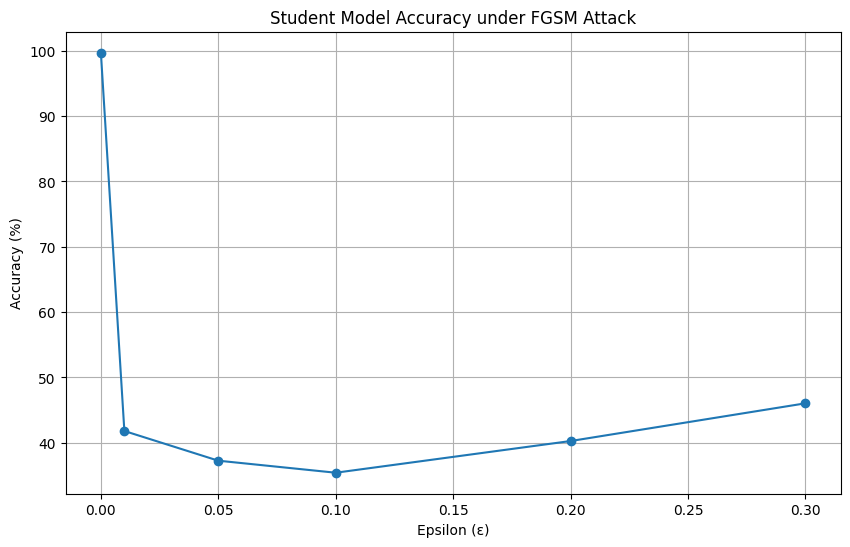

In [ ]:
# Step 7: Evaluate the Student Model Before and After FGSM Attack
def evaluate_model(model, loader, device, epsilon=0):
    model.eval()
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        if epsilon > 0:
            data = fgsm_attack(model, data, target, epsilon)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    accuracy = 100. * correct / total
    return accuracy

print("Evaluating student model on clean data...")
student_clean_acc = evaluate_model(student_model, test_loader, DEVICE)
print(f"Student Model Accuracy on Clean Data: {student_clean_acc:.2f}%")

print("Evaluating student model under FGSM attack...")
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]
student_attack_acc = []
for eps in epsilon_values:
    acc = evaluate_model(student_model, test_loader, DEVICE, eps)
    student_attack_acc.append(acc)
    print(f"Epsilon {eps}: Accuracy = {acc:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot([0] + epsilon_values, [student_clean_acc] + student_attack_acc, marker='o')
plt.xlabel("Epsilon (ε)")
plt.ylabel("Accuracy (%)")
plt.title("Student Model Accuracy under FGSM Attack")
plt.grid(True)
plt.show()

Evaluating teacher model on clean data...
Teacher Model Accuracy on Clean Data: 72.74%
Evaluating teacher model under FGSM attack...
Epsilon 0.01: Accuracy = 80.05%
Epsilon 0.05: Accuracy = 77.59%
Epsilon 0.1: Accuracy = 76.37%
Epsilon 0.2: Accuracy = 72.99%
Epsilon 0.3: Accuracy = 70.47%


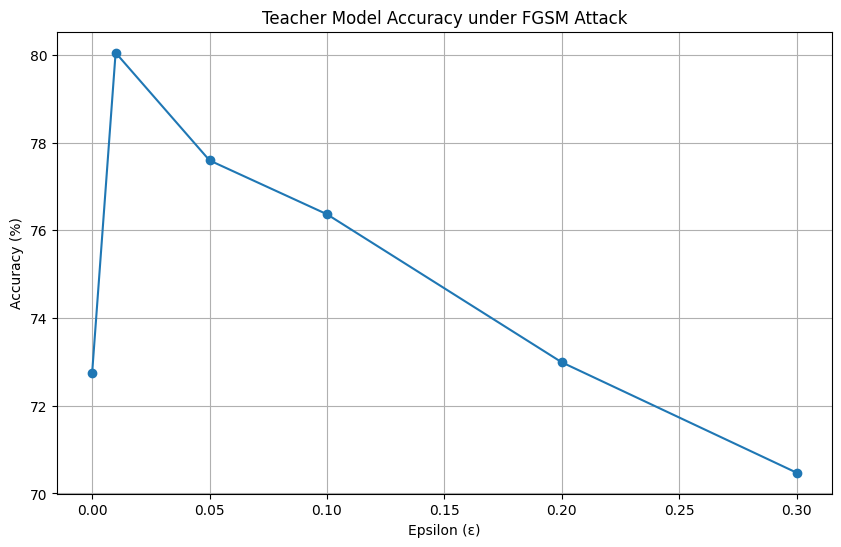

In [ ]:
# Step 8: Evaluate the Teacher Model Before and After FGSM Attack
print("Evaluating teacher model on clean data...")
teacher_clean_acc = evaluate_model(teacher_model, test_loader, DEVICE)
print(f"Teacher Model Accuracy on Clean Data: {teacher_clean_acc:.2f}%")

print("Evaluating teacher model under FGSM attack...")
teacher_attack_acc = []
for eps in epsilon_values:
    acc = evaluate_model(teacher_model, test_loader, DEVICE, eps)
    teacher_attack_acc.append(acc)
    print(f"Epsilon {eps}: Accuracy = {acc:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot([0] + epsilon_values, [teacher_clean_acc] + teacher_attack_acc, marker='o')
plt.xlabel("Epsilon (ε)")
plt.ylabel("Accuracy (%)")
plt.title("Teacher Model Accuracy under FGSM Attack")
plt.grid(True)
plt.show()

Confusion Matrix for Student Model:


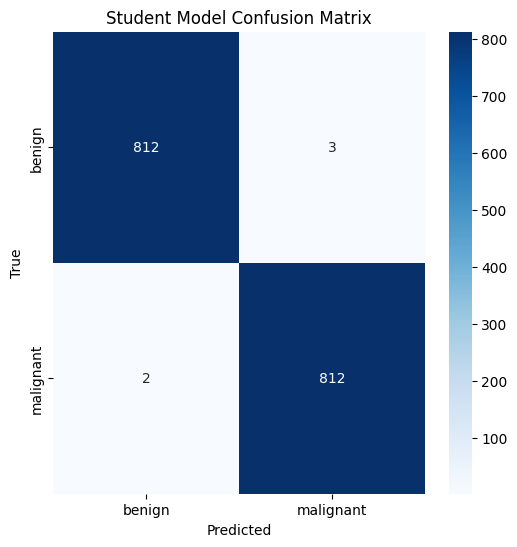

Confusion Matrix for Teacher Model:


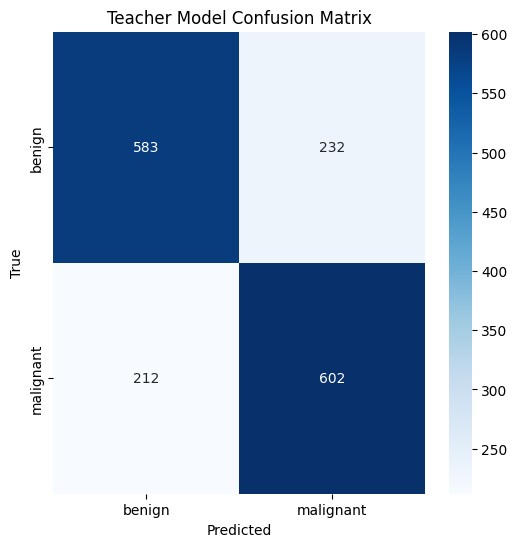

In [ ]:
# Step 9: Confusion Matrix
def plot_confusion_matrix(model, loader, device, title="Confusion Matrix", classes=None): # Added classes argument
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))

    # Use classes argument if provided, otherwise try to infer from loader
    if classes is not None:
        xticklabels = yticklabels = classes
    else:
        try:
            xticklabels = yticklabels = loader.dataset.classes
        except AttributeError:
            xticklabels = yticklabels = range(cm.shape[0]) # Fallback to indices

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=xticklabels, yticklabels=yticklabels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

print("Confusion Matrix for Student Model:")
# Pass test_dataset.classes to the function
plot_confusion_matrix(student_model, test_loader, DEVICE, title="Student Model Confusion Matrix", classes=test_dataset.classes)
print("Confusion Matrix for Teacher Model:")
# Pass test_dataset.classes to the function
plot_confusion_matrix(teacher_model, test_loader, DEVICE, title="Teacher Model Confusion Matrix", classes=test_dataset.classes)

In [ ]:
# Step 10: Evaluate Precision, Recall, and F1-Score
def evaluate_metrics(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

print("Evaluation Metrics for Student Model:")
evaluate_metrics(student_model, test_loader, DEVICE)
print("Evaluation Metrics for Teacher Model:")
evaluate_metrics(teacher_model, test_loader, DEVICE)

Evaluation Metrics for Student Model:
Precision: 0.9963
Recall:    0.9975
F1-Score:  0.9969
Evaluation Metrics for Teacher Model:
Precision: 0.7218
Recall:    0.7396
F1-Score:  0.7306
